In [1]:
%load_ext autoreload
%autoreload 2

# **Imports**

In [2]:
from getModel import blModel, eeModel, eeModel_V0, eeModel_V1, eeModel_V2, eeModel_V3

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import copy

import torchvision.transforms as T
import pickle
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# **Self-supervised learning solutions**

We will experiment with these solutions with promising results in speech and RF signal tasks
- BYOL (Bootstrap Your Own Latent)
- SimCLR (Simple Constrastive Learning)
- MoCo-v3 (Momentum Constrast)
- DINO (Self-distillation with No labels)

## **BYOL**

In [3]:
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.transforms.byol_transform import BYOLTransform
from lightly.utils.scheduler import cosine_schedule
from lightly.models.utils import deactivate_requires_grad, update_momentum
import transforms as RST

In [4]:
class BYOLR(nn.Module):
    def __init__(self, backbone, feature_dim=256):
        super(BYOLR, self).__init__()

        self.online_encoder = backbone
        self.projection_head = BYOLProjectionHead(
            input_dim=feature_dim, hidden_dim=1024, output_dim=feature_dim)
        self.prediction_head = BYOLPredictionHead(
            input_dim=feature_dim, hidden_dim=1024, output_dim=feature_dim)

        self.target_encoder = copy.deepcopy(self.online_encoder)
        self.target_projection_head = copy.deepcopy(self.projection_head)

        # deactivate the requires_grad for the target encoder pipeline
        deactivate_requires_grad(self.target_encoder)
        deactivate_requires_grad(self.target_projection_head)

    def forward(self, x):
        # forward pass for the online encoder
        rep = self.online_encoder(x).flatten(start_dim=1)
        proj = self.projection_head(rep)
        pred = self.prediction_head(proj)
        return pred

    def forward_target(self, x):
        # forward pass for the target encoder
        rep = self.target_encoder(x).flatten(start_dim=1)
        proj = self.target_projection_head(rep)
        proj = proj.detach()
        return proj

In [5]:
backbone = blModel()
backbone = nn.Sequential(*list(backbone.children())[:-1])
byol_model = BYOLR(backbone)

## **SimCLR**

In [6]:
from lightly.models.modules import SimCLRProjectionHead

In [7]:
class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(256, 512, 128)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [8]:
simclr_model = SimCLR(backbone)

# **Data**

Read synthetic data for signal classification and signal denoising task

## **Signal Classification**

In [9]:
with open('./Data/RML22.pickle.01A', 'rb') as f:
    data = pickle.load(f, encoding="latin1")

In [10]:
mods = [lst[0] for lst in data.keys()]
snrs = [lst[1] for lst in data.keys()]

In [11]:
len(mods), len(snrs)

(210, 210)

In [12]:
dataset = []
for mod, snr in zip(mods, snrs):
    # print(data[(mod, snr)].shape, mod, snr)
    dataset.extend(data[(mod, snr)])

dataset = np.array(dataset)
dataset.shape  # (210*2000, 2, 128)

(420000, 2, 128)

In [13]:
num_classes = len(set(mods))
name2label = {name: i for i, name in enumerate(set(mods))}
seen = set()
seen_add = seen.add
labels = torch.from_numpy(np.array(
    [name2label[name] for name in mods]))
labels = torch.repeat_interleave(labels, 2000)

In [14]:
class IQDataset:
    def __init__(self, x, y, transform_x=None, transform_y=None):
        self.x = x
        self.y = y
        self.transform_x = transform_x
        self.transform_y = transform_y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        if self.transform_x:
            x = self.transform_x(x)
        elif isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        if self.transform_y:
            y = self.transform_y(y)
        elif isinstance(y, np.ndarray):
            y = torch.from_numpy(y)
        return x, y

In [15]:
# transforms
txforms = T.Compose([
    T.Lambda(lambda x: torch.from_numpy(x).float()),
    RST.RandomResample(max_rate=8),
    RST.RandomDCShift(max_shift=3),
    RST.RandomAmplitudeScale(scale_factor=0.1),
    # RST.RandomPhaseShift(),
    # RST.RandomFrequencyShift(),
    RST.RandomZeroMasking(max_mask_size=32, dim=-1),
    RST.RandomTimeShift(max_shift=16),
    # RST.TimeReversal(),
    # RST.RandomAddNoise(std=0.001)
    RST.RandomTimeCrop(crop_size=128),  # without time crop we face the problem of different lengths # noqa
])

transforms = BYOLTransform(
    view_1_transform=txforms,
    view_2_transform=txforms
)

In [16]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=0)
dev_idx, val_idx = next(sss.split(dataset, labels))

ssl_data = IQDataset(
    dataset[dev_idx], labels[dev_idx], transform_x=transforms)
train_data = IQDataset(
    dataset[dev_idx], labels[dev_idx])
val_data = IQDataset(
    dataset[val_idx], labels[val_idx])

len(ssl_data), len(train_data), len(val_data)

(252000, 252000, 168000)

In [17]:
one_Xs, _ = ssl_data[0]
one_x0, one_x1 = one_Xs
one_x0.shape, one_x1.shape

(torch.Size([2, 128]), torch.Size([2, 128]))

Text(0.5, 1.0, 'View 2')

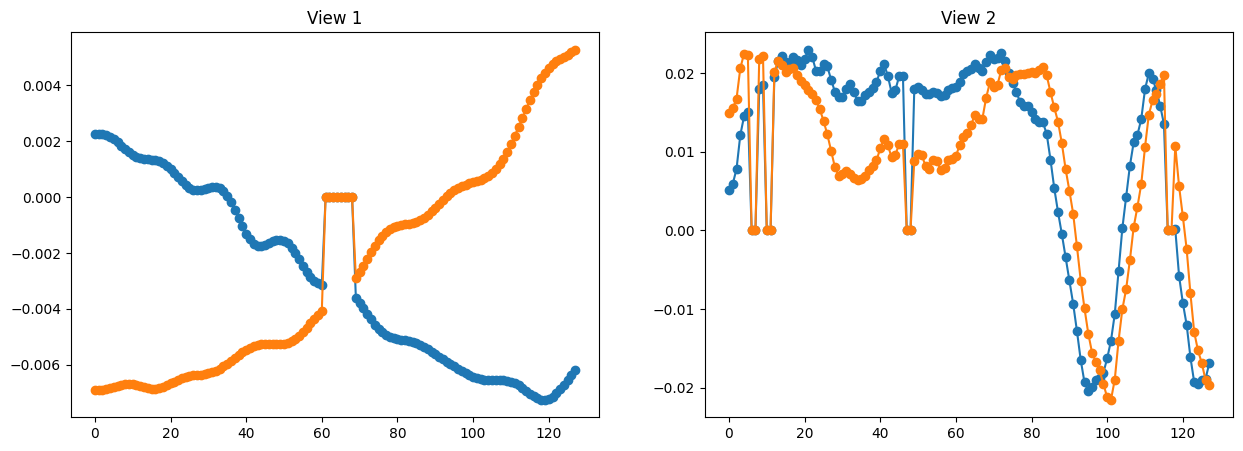

In [18]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(one_x0.T, marker='o')
ax1.set_title('View 1')
ax2.plot(one_x1.T, marker='o')
ax2.set_title('View 2')

In [19]:

ssl_dataloader = DataLoader(
    ssl_data, batch_size=256, shuffle=True, drop_last=True, num_workers=4)
train_dataloader = DataLoader(
    train_data, batch_size=256, shuffle=True, drop_last=True, num_workers=4)
val_dataloader = DataLoader(
    val_data, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

In [20]:
for batch, _ in ssl_dataloader:
    x0, x1 = batch
    print(x0.shape, x1.shape)
    break

torch.Size([256, 2, 128]) torch.Size([256, 2, 128])


# **Training**

### **BYOL**

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"


byol_model.to(device)

BYOLR(
  (online_encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [22]:
byol_model.online_encoder(x0.to(device)).shape

torch.Size([256, 256])

In [23]:
def loss_fn(x0: torch.Tensor, x1: torch.Tensor):
    return 2. - 2. * F.cosine_similarity(x0, x1, dim=-1).mean()

In [24]:
classifier = nn.Sequential(
    nn.Linear(in_features=256, out_features=256),
    nn.Dropout(0.5),
    nn.Linear(in_features=256, out_features=64),
    nn.Dropout(0.5),
    nn.Linear(in_features=64, out_features=num_classes)
).to(device)

In [25]:
def accuracy(y_pred, y_true):
    return (y_pred.argmax(dim=-1) == y_true).float().mean()

In [26]:
critertion = loss_fn
byol_optimizer = torch.optim.Adam(byol_model.parameters(), lr=3e-4)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

EPOCHS = 10

history = {
    "ssl_loss": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "epochs": []
}

for epoch in range(EPOCHS):
    running_ssl_tloss = 0.0
    running_tloss = 0.0
    running_vloss = 0.0
    byol_model.train()
    classifier.train()
    momentum_val = cosine_schedule(epoch, EPOCHS, 0.996, 1)
    for batch, _ in ssl_dataloader:
        x0, x1 = batch
        update_momentum(byol_model.online_encoder,
                        byol_model.target_encoder, m=momentum_val)
        update_momentum(byol_model.projection_head,
                        byol_model.target_projection_head, m=momentum_val)
        x0, x1 = x0.to(device), x1.to(device)
        byol_optimizer.zero_grad()
        # Stage 1
        # v0 -> backbone -> projection_head -> prediction_head -> p0
        # v1 -> target_backbone -> target_projection_head -> z1
        # Stage 2
        # v1 -> backbone -> projection_head -> prediction_head -> p1
        # v0 -> target_backbone -> target_projection_head -> z0
        # Symmetric loss
        # loss = loss_fn(p0, z1) + loss_fn(p1, z0)
        p0 = byol_model(x0)
        z1 = byol_model.forward_target(x1)
        p1 = byol_model(x1)
        z0 = byol_model.forward_target(x0)
        loss = critertion(p0, z1) + critertion(p1, z0)
        loss.backward()
        byol_optimizer.step()
        running_ssl_tloss += loss.item()

    avg_tloss = running_ssl_tloss / len(train_dataloader)
    print(f"Epoch: {epoch}\n\tSSL Train Loss: {avg_tloss}")
    history['ssl_loss'].append(avg_tloss)

    # validate SSL with MLP for clasification task
    # train the classifier
    for data, target in train_dataloader:
        data, target = data.to(device), target.to(device)
        classifier_optimizer.zero_grad()
        output = classifier(byol_model.online_encoder(data))
        loss = F.cross_entropy(output, target)
        loss.backward()
        classifier_optimizer.step()
        running_tloss += loss.item()

    avg_tloss = running_tloss / len(train_dataloader)
    print(f"\tTrain Loss: {avg_tloss}")
    history['train_loss'].append(avg_tloss)
    history['epochs'].append(epoch+1)

    classifier.eval()
    for data, target in val_dataloader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = classifier(byol_model.online_encoder(data))
            loss = F.cross_entropy(output, target)
            running_vloss += loss.item()
    avg_vloss = running_vloss / len(val_dataloader)
    print(f"\tValidation Loss: {avg_vloss}")
    history['val_loss'].append(avg_vloss)

Epoch: 0, SSL Train Loss: 1.1329467385038128
Epoch: 0, Train Loss: 2.0228833404740665
Epoch: 0, Validation Loss: 1.9636392618786074
Epoch: 1, SSL Train Loss: 0.8245300172063393
Epoch: 1, Train Loss: 1.847905100239971
Epoch: 1, Validation Loss: 1.7986861764931061
Epoch: 2, SSL Train Loss: 0.8125394535500828
Epoch: 2, Train Loss: 1.7384017850083064
Epoch: 2, Validation Loss: 1.6818015767740513
Epoch: 3, SSL Train Loss: 0.8038522668970309
Epoch: 3, Train Loss: 1.6578845047369235
Epoch: 3, Validation Loss: 1.6066515409420252
Epoch: 4, SSL Train Loss: 0.780314391706048
Epoch: 4, Train Loss: 1.5901017634849237
Epoch: 4, Validation Loss: 1.5521352944308764
Epoch: 5, SSL Train Loss: 0.7460566011628484
Epoch: 5, Train Loss: 1.5652249792242439
Epoch: 5, Validation Loss: 1.5131182456488297
Epoch: 6, SSL Train Loss: 0.7247392454040729
Epoch: 6, Train Loss: 1.545836881529994
Epoch: 6, Validation Loss: 1.5013621336067466
Epoch: 7, SSL Train Loss: 0.7079331000161365
Epoch: 7, Train Loss: 1.5537606928

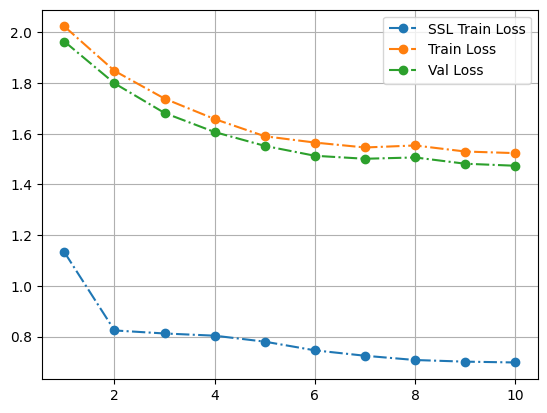

In [29]:
plt.plot(history["epochs"], history["ssl_loss"],
         "o-.", label='SSL Train Loss')
plt.plot(history["epochs"], history["train_loss"],
         "o-.", label='Train Loss')
plt.plot(history["epochs"], history["val_loss"],
         "o-.", label='Val Loss')
plt.grid()
plt.legend()